# 02_train
- Author: 
- Date: 2025-10-23
- Goal: 모델링/학습/통계/시각화
- Input: 
- Output: 
- Metrics: acc@val, loss@train
- Repro: seed=42, device=auto, config=../configs/


In [1]:
# This cell is only needed if xgboost is not installed in your environment.
# In Colab, run this once and then restart the runtime if necessary.
# option Cell !!! 
# xgboost 안깔려 있으면 주석 풀고 실행!
#!pip install -q xgboost

In [2]:
# ================================================================
# 02. Classical ML Training on Colored MNIST
#    - Uses preprocessed 80k Colored MNIST npz
#    - Normalization only in training via StandardScaler (in Pipeline)
#    - Baseline: Logistic Regression
#    - Other models: KNN, SVM, Decision Tree, Random Forest, XGBoost
#    - Select models via ACTIVE_MODELS
#    - Optional GridSearchCV per model
#    - Tasks: digit / foreground color / background color
#    - Outputs: metrics CSV + confusion matrices + feature importance + examples
# ================================================================


# ================================
# Cell 1. Imports & global config
# ================================
import os
import random
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
)

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# XGBoost (install if necessary: !pip install xgboost)
from xgboost import XGBClassifier

# For notebook
%matplotlib inline

# Global random seed for reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Matplotlib configuration (English labels only)
plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["axes.unicode_minus"] = False

print("[INFO] Libraries imported.")

[INFO] Libraries imported.


In [3]:
# ===================================
# Cell 2. Paths & dataset information
# ===================================
# Assume this notebook is placed at project root
BASE_DIR = os.getcwd()

# Directory where preprocessed npz is saved
PROC_DIR = os.path.join(BASE_DIR, "data", "processed", "colored_mnist")
NPZ_PATH = os.path.join(PROC_DIR, "colored_mnist_80k_splits_8_1_1.npz")

# Output directories for metrics and figures
RESULTS_METRICS_DIR = os.path.join(BASE_DIR, "results", "metrics")
RESULTS_FIGURES_DIR = os.path.join(BASE_DIR, "results", "figures")

os.makedirs(RESULTS_METRICS_DIR, exist_ok=True)
os.makedirs(RESULTS_FIGURES_DIR, exist_ok=True)

# Shape of a colored image (for visualization only)
IMG_SHAPE = (28, 28, 3)

print("[INFO] BASE_DIR      :", BASE_DIR)
print("[INFO] NPZ_PATH      :", NPZ_PATH)
print("[INFO] METRICS_DIR   :", RESULTS_METRICS_DIR)
print("[INFO] FIGURES_DIR   :", RESULTS_FIGURES_DIR)

[INFO] BASE_DIR      : /Users/jaehun_jung/colored-mnist-classification/notebooks
[INFO] NPZ_PATH      : /Users/jaehun_jung/colored-mnist-classification/notebooks/data/processed/colored_mnist/colored_mnist_80k_splits_8_1_1.npz
[INFO] METRICS_DIR   : /Users/jaehun_jung/colored-mnist-classification/notebooks/results/metrics
[INFO] FIGURES_DIR   : /Users/jaehun_jung/colored-mnist-classification/notebooks/results/figures


In [4]:
# ==========================================
# Cell 3. Load processed Colored MNIST splits
# ==========================================
# Load npz file generated by 01_preprocessing_colored_mnist.ipynb
if not os.path.exists(NPZ_PATH):
    raise FileNotFoundError(f"[ERROR] Processed dataset not found at: {NPZ_PATH}")

data = np.load(NPZ_PATH)

# Flattened colored images: (N, 2352), float32, values in [0, 255]
X_train = data["X_train"]
X_val   = data["X_val"]
X_test  = data["X_test"]

# Digit labels (0-9)
y_digit_train = data["y_digit_train"]
y_digit_val   = data["y_digit_val"]
y_digit_test  = data["y_digit_test"]

# Foreground color labels (0-6: ROYGBIV)
y_fg_train = data["y_fg_train"]
y_fg_val   = data["y_fg_val"]
y_fg_test  = data["y_fg_test"]

# Background color labels (0-6: ROYGBIV)
y_bg_train = data["y_bg_train"]
y_bg_val   = data["y_bg_val"]
y_bg_test  = data["y_bg_test"]

print("[INFO] Dataset loaded from npz.")
print("  X_train shape:", X_train.shape, "dtype:", X_train.dtype)
print("  X_val   shape:", X_val.shape)
print("  X_test  shape:", X_test.shape)
print("  y_digit_train shape:", y_digit_train.shape)
print("  y_fg_train    shape:", y_fg_train.shape)
print("  y_bg_train    shape:", y_bg_train.shape)

# Basic sanity checks
assert X_train.shape[1] == 28 * 28 * 3, "[ERROR] Feature dimension must be 28*28*3."
assert len(X_train) == len(y_digit_train) == len(y_fg_train) == len(y_bg_train)


[INFO] Dataset loaded from npz.
  X_train shape: (64000, 2352) dtype: float32
  X_val   shape: (8000, 2352)
  X_test  shape: (8000, 2352)
  y_digit_train shape: (64000,)
  y_fg_train    shape: (64000,)
  y_bg_train    shape: (64000,)


In [5]:
# =====================================================
# Cell 4. Task selection helper (digit / fg / bg labels)
# =====================================================
# Map each task name to its corresponding labels and description
TASK_LABEL_INFO = {
    "digit": {
        "y_train": y_digit_train,
        "y_val":   y_digit_val,
        "y_test":  y_digit_test,
        "task_desc": "Digit classification (0-9)",
    },
    "fg": {
        "y_train": y_fg_train,
        "y_val":   y_fg_val,
        "y_test":  y_fg_test,
        "task_desc": "Foreground color classification (7 classes)",
    },
    "bg": {
        "y_train": y_bg_train,
        "y_val":   y_bg_val,
        "y_test":  y_bg_test,
        "task_desc": "Background color classification (7 classes)",
    },
}

# Which tasks to run (you can restrict this list when debugging)
ACTIVE_TASKS = ["fg", "bg"]  # e.g., ["digit"] for digit-only experiments
print("[INFO] Active tasks:", ACTIVE_TASKS)


[INFO] Active tasks: ['fg', 'bg']


In [6]:
# ==========================================
# Cell 5. Visualization helpers (EDA)
# ==========================================
def reconstruct_images(X_flat, n_samples=16):
    """
    Reconstruct RGB images from flattened feature vectors for visualization.
    """
    n = min(n_samples, X_flat.shape[0])
    idxs = np.random.choice(X_flat.shape[0], size=n, replace=False)
    imgs = X_flat[idxs].reshape(n, *IMG_SHAPE)
    return imgs, idxs


def plot_sample_images(X_flat, y, title, n_samples=16):
    """
    Plot a grid of sample images with their labels.
    """
    imgs, idxs = reconstruct_images(X_flat, n_samples=n_samples)
    n = imgs.shape[0]
    cols = min(8, n)
    rows = int(np.ceil(n / cols))

    plt.figure(figsize=(cols * 1.5, rows * 1.5))
    for i, (img, idx) in enumerate(zip(imgs, idxs)):
        ax = plt.subplot(rows, cols, i + 1)
        ax.imshow(img / 255.0)  # scale to [0,1] for visualization
        ax.axis("off")
        ax.set_title(str(int(y[idx])), fontsize=8)
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()


def plot_label_distribution(y_train, y_val, y_test, task_name):
    """
    Plot label distribution for train/val/test splits for a given task.
    """
    def counts(y):
        return pd.Series(y).value_counts().sort_index()

    train_c = counts(y_train)
    val_c   = counts(y_val)
    test_c  = counts(y_test)

    df = pd.DataFrame({
        "label": train_c.index,
        "train": train_c.values,
        "val":   val_c.values,
        "test":  test_c.values,
    })

    print(f"\n[EDA] Label distribution for task = {task_name}")
    print(df)

    x = np.arange(len(df["label"]))
    width = 0.25

    plt.figure(figsize=(8, 4))
    plt.bar(x - width, df["train"], width=width, label="train")
    plt.bar(x,         df["val"],   width=width, label="val")
    plt.bar(x + width, df["test"],  width=width, label="test")

    plt.xticks(x, df["label"])
    plt.xlabel("Label")
    plt.ylabel("Count")
    plt.title(f"Label distribution per split ({task_name})")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [7]:
# ==========================================
# Cell 6. Evaluation & plotting utilities
# ==========================================
def compute_metrics(y_true, y_pred, average="macro"):
    """
    Compute accuracy, precision, recall, and F1-score (macro-averaged by default).
    """
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average=average, zero_division=0
    )
    return acc, prec, rec, f1


def plot_confusion_matrix(y_true, y_pred, classes, title, save_path=None):
    """
    Plot normalized confusion matrix as a heatmap.
    """
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    #cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        xticklabels=classes,
        yticklabels=classes,
        cmap="YlGnBu",
    )
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title(title)
    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi=200)
        print("[INFO] Saved confusion matrix to:", save_path)

    plt.show()


def show_prediction_examples(model_name, pipeline, X_test, y_true, task_name, n=12):
    """
    Show test images with true vs predicted labels for qualitative verification.
    """
    n = min(n, X_test.shape[0])
    idxs = np.random.choice(X_test.shape[0], size=n, replace=False)
    X_sample = X_test[idxs]
    y_sample_true = y_true[idxs]
    y_sample_pred = pipeline.predict(X_sample)

    imgs = X_sample.reshape(n, *IMG_SHAPE)

    cols = min(6, n)
    rows = int(np.ceil(n / cols))

    plt.figure(figsize=(cols * 2, rows * 2.2))
    for i in range(n):
        ax = plt.subplot(rows, cols, i + 1)
        ax.imshow(imgs[i] / 255.0)
        ax.axis("off")
        ax.set_title(
            f"T:{int(y_sample_true[i])} / P:{int(y_sample_pred[i])}",
            fontsize=8,
        )
    plt.suptitle(f"{task_name} - {model_name}: prediction examples", fontsize=14)
    plt.tight_layout()
    plt.show()


def plot_feature_importance_heatmap(feature_importances, title, save_path=None):
    """
    Visualize feature importances (flattened 2352-dim vector) as a heatmap over 28x28 pixels,
    by averaging the 3 RGB channels.
    """
    if feature_importances.shape[0] != 28 * 28 * 3:
        print("[WARN] Unexpected feature_importances length:", feature_importances.shape[0])
        return

    # Reshape to (28, 28, 3) and average across RGB channels
    imp_3d = feature_importances.reshape(28, 28, 3)
    imp_2d = imp_3d.mean(axis=2)

    plt.figure(figsize=(4, 4))
    sns.heatmap(imp_2d, cmap="viridis")
    plt.title(title)
    plt.axis("off")
    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi=200)
        print("[INFO] Saved feature importance heatmap to:", save_path)

    plt.show()


In [8]:
# ==========================================
# Cell 7. Model definitions & GridSearch configs
# ==========================================
# Base estimators (without scaling; scaling will be part of sklearn Pipeline)
BASE_MODELS = {
    # Baseline: Logistic Regression (multiclass)
    "logreg": LogisticRegression(
        max_iter=500,
        n_jobs=-1,
        multi_class="auto",
        solver="lbfgs",
        random_state=RANDOM_SEED,
    ),
    # k-Nearest Neighbors
    "knn": KNeighborsClassifier(n_neighbors=5, p = 2, metric= 'minkowski', weights ='distance'),
    # Support Vector Machine with RBF kernel
    "svm": SVC(decision_function_shape='ovr', gamma='auto'),
    # Decision Tree
    "tree": DecisionTreeClassifier( 
        criterion="entropy",       # splitting criterion ('gini' or 'entropy')
        max_depth=None,         # allow the tree to grow until pure or min_samples constraints
        min_samples_split=5,    # minimum samples required to split an internal node
        min_samples_leaf=3,     # minimum samples required at a leaf node
     ),
    # Random Forest
    "rf": RandomForestClassifier( 
        n_estimators=500,     # number of trees in the forest (can increase if time allows)
        criterion="entropy",     # splitting criterion
        max_depth=None,       # allow deep trees; can limit for speed
        min_samples_split=2,  # minimum samples to split
        min_samples_leaf=1,   # minimum samples at leaf
        n_jobs=-1,            # use all CPU cores
    ),
    # XGBoost (tree-based gradient boosting)
    "xgb": XGBClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="multi:softmax",  # multi-class classification with discrete outputs
        tree_method="hist",         # fast histogram-based algorithm
        eval_metric="mlogloss",
        random_state=RANDOM_SEED,
        n_jobs=-1,
    ),
}

# Whether each model type needs feature scaling (StandardScaler)
NEEDS_SCALING = {
    "logreg": True,
    "knn": True,
    "svm": True,
    "tree": False,  # Tree-based models are scale-invariant
    "rf":   False,
    "xgb":  False,
}

# Hyperparameter grids for optional GridSearchCV (small for practicality)
PARAM_GRIDS = {
    "logreg": {
        "clf__C": [0.1, 1.0, 10.0],
    },
    "knn": {
        "clf__n_neighbors": [3, 5, 7],
        "clf__weights": ["uniform", "distance"],
    },
    "svm": {
        "clf__C": [0.5, 1.0, 2.0],
        "clf__gamma": ["scale", 0.01, 0.001],
    },
    "tree": {
        "clf__max_depth": [None, 10, 20],
        "clf__min_samples_split": [2, 5, 10],
    },
    "rf": {
        "clf__n_estimators": [100, 200],
        "clf__max_depth": [None, 20],
        "clf__max_features": ["sqrt", "log2"],
    },
    "xgb": {
        "clf__n_estimators": [100, 200],
        "clf__max_depth": [4, 6],
        "clf__learning_rate": [0.05, 0.1],
    },
}

# Model-wise GridSearch on/off flag
USE_GRIDSEARCH = {
    # Baseline logistic regression is fixed by default
    "logreg": False,
    "knn":   False,
    "svm":   False,
    "tree":  False,
    "rf":    False,
    "xgb":   False,
}

# Which models to run (can be sub-selected)
# e.g., ACTIVE_MODELS = ["logreg", "xgb"] to only run baseline + XGBoost
ACTIVE_MODELS = ['svm']
print("[INFO] Active models:", ACTIVE_MODELS)


def build_pipeline(model_name, base_estimator):
    """
    Build sklearn Pipeline for a given model:
      - If NEEDS_SCALING[model_name] is True:
          [StandardScaler] -> [Classifier]
      - Otherwise:
          [Classifier] only
    """
    if NEEDS_SCALING[model_name]:
        steps = [("scaler", StandardScaler()), ("clf", base_estimator)]
    else:
        steps = [("clf", base_estimator)]
    pipe = Pipeline(steps)
    return pipe


def train_single_model(
    model_name,
    X_train,
    y_train,
    X_val,
    y_val,
    task_name,
    use_gridsearch=True,
):
    """
    Train a single model (optionally with GridSearchCV) and evaluate on val set.

    Returns
    -------
    best_pipeline : trained Pipeline
    metrics_val   : dict with accuracy, precision, recall, f1 (macro)
    """
    print("\n==============================")
    print(f"[TASK: {task_name}] Training model: {model_name}")
    print("==============================")

    base_estimator = BASE_MODELS[model_name]
    pipe = build_pipeline(model_name, base_estimator)

    if use_gridsearch and model_name in PARAM_GRIDS:
        param_grid = PARAM_GRIDS[model_name]
        print("[INFO] Running GridSearchCV for", model_name)
        grid = GridSearchCV(
            pipe,
            param_grid=param_grid,
            cv=3,
            n_jobs=-1,
            scoring="accuracy",
            verbose=1,
        )
        grid.fit(X_train, y_train)
        best_pipeline = grid.best_estimator_
        print("[INFO] Best params:", grid.best_params_)
        print("[INFO] Best CV accuracy:", grid.best_score_)
    else:
        print("[INFO] Training without GridSearch (fixed hyperparameters).")
        pipe.fit(X_train, y_train)
        best_pipeline = pipe

    # Validation performance
    y_val_pred = best_pipeline.predict(X_val)
    acc, prec, rec, f1 = compute_metrics(y_val, y_val_pred, average="macro")

    print("\n[VAL] metrics (macro) for", model_name)
    print(f"  accuracy : {acc:.4f}")
    print(f"  precision: {prec:.4f}")
    print(f"  recall   : {rec:.4f}")
    print(f"  f1-score : {f1:.4f}")

    print("\n[VAL] classification_report:")
    print(classification_report(y_val, y_val_pred, digits=4))

    metrics_val = {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
    }

    return best_pipeline, metrics_val



[INFO] Active models: ['svm']




##########################################
### Task: fg - Foreground color classification (7 classes)
##########################################

[EDA] Label distribution for task = fg
   label  train   val  test
0      0   9211  1119  1122
1      1   9062  1152  1167
2      2   9184  1148  1168
3      3   9166  1138  1118
4      4   9186  1125  1085
5      5   9236  1138  1143
6      6   8955  1180  1197


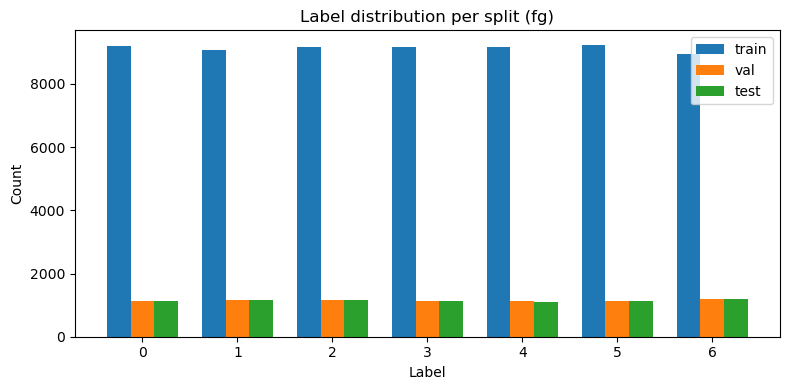

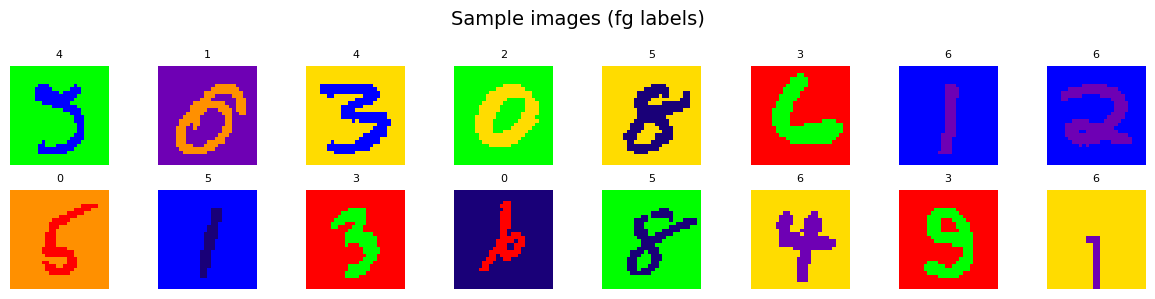


[TASK: fg] Training model: svm
[INFO] Training without GridSearch (fixed hyperparameters).

[VAL] metrics (macro) for svm
  accuracy : 0.9958
  precision: 0.9958
  recall   : 0.9958
  f1-score : 0.9958

[VAL] classification_report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      1119
           1     0.9770    0.9939    0.9854      1152
           2     0.9938    0.9765    0.9851      1148
           3     1.0000    1.0000    1.0000      1138
           4     1.0000    1.0000    1.0000      1125
           5     1.0000    1.0000    1.0000      1138
           6     1.0000    1.0000    1.0000      1180

    accuracy                         0.9958      8000
   macro avg     0.9958    0.9958    0.9958      8000
weighted avg     0.9958    0.9958    0.9957      8000


[TEST] fg - svm
  accuracy : 0.9956
  precision: 0.9958
  recall   : 0.9957
  f1-score : 0.9957

[TEST] classification_report:
              precision    recall  f1-scor

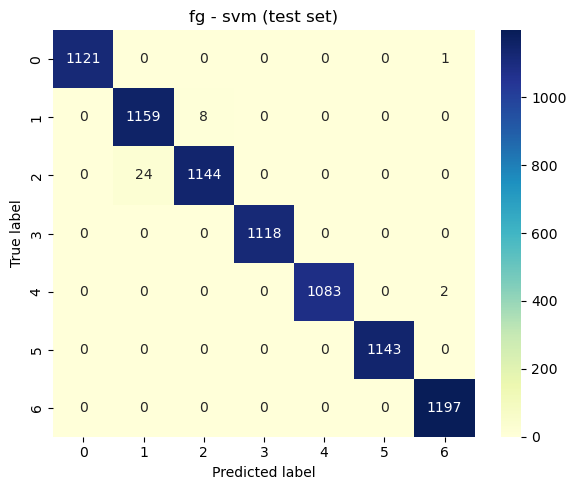

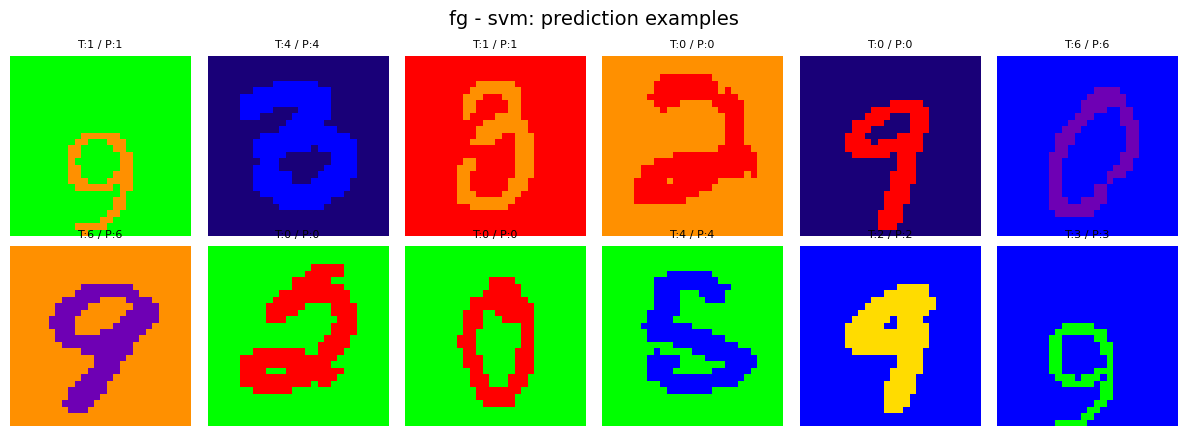



##########################################
### Task: bg - Background color classification (7 classes)
##########################################

[EDA] Label distribution for task = bg
   label  train   val  test
0      0   9111  1144  1157
1      1   9240  1094  1132
2      2   9021  1165  1090
3      3   9008  1163  1205
4      4   9208  1137  1144
5      5   9150  1184  1165
6      6   9262  1113  1107


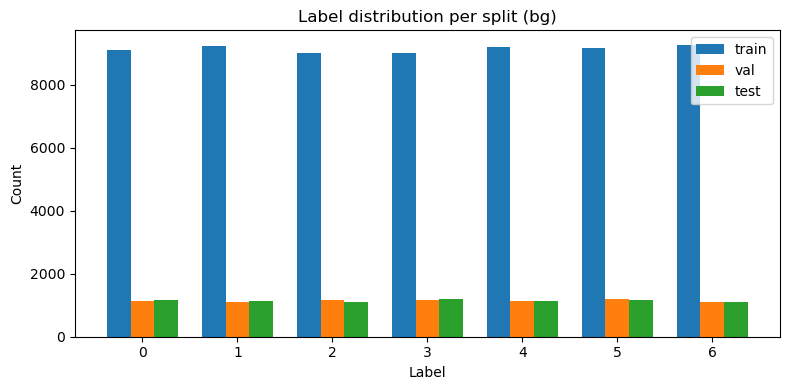

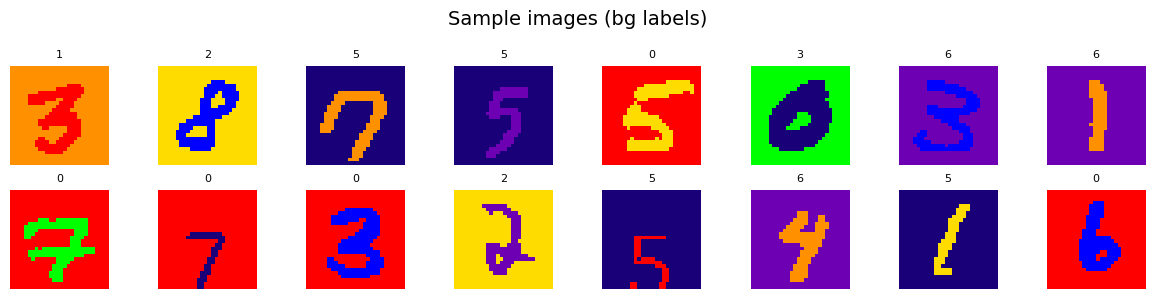


[TASK: bg] Training model: svm
[INFO] Training without GridSearch (fixed hyperparameters).

[VAL] metrics (macro) for svm
  accuracy : 1.0000
  precision: 1.0000
  recall   : 1.0000
  f1-score : 1.0000

[VAL] classification_report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      1144
           1     1.0000    1.0000    1.0000      1094
           2     1.0000    1.0000    1.0000      1165
           3     1.0000    1.0000    1.0000      1163
           4     1.0000    1.0000    1.0000      1137
           5     1.0000    1.0000    1.0000      1184
           6     1.0000    1.0000    1.0000      1113

    accuracy                         1.0000      8000
   macro avg     1.0000    1.0000    1.0000      8000
weighted avg     1.0000    1.0000    1.0000      8000


[TEST] bg - svm
  accuracy : 1.0000
  precision: 1.0000
  recall   : 1.0000
  f1-score : 1.0000

[TEST] classification_report:
              precision    recall  f1-scor

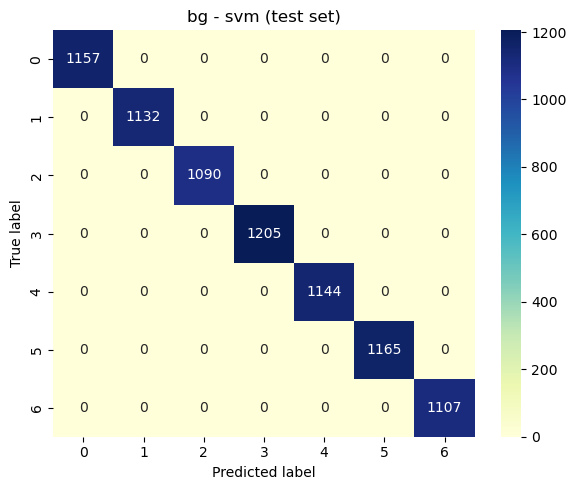

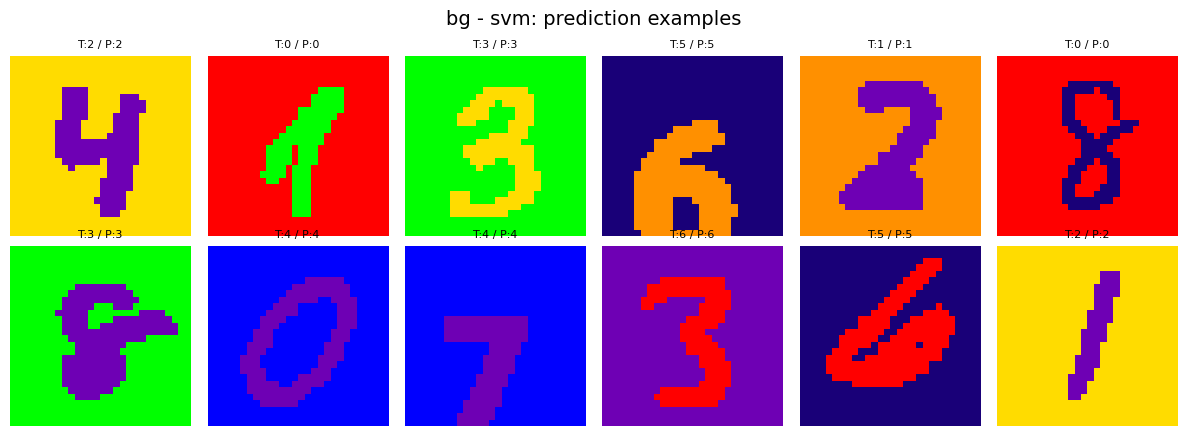

In [9]:
# ==========================================
# Cell 8. Main training loop over tasks/models
# ==========================================
all_results = []  # will store metrics for all (task, model, split)

for task_name in ACTIVE_TASKS:
    info = TASK_LABEL_INFO[task_name]
    y_train_task = info["y_train"]
    y_val_task   = info["y_val"]
    y_test_task  = info["y_test"]
    task_desc    = info["task_desc"]

    print("\n\n##########################################")
    print(f"### Task: {task_name} - {task_desc}")
    print("##########################################")

    # EDA: label distribution
    plot_label_distribution(y_train_task, y_val_task, y_test_task, task_name)

    # EDA: sample images (using training split, labels from this task)
    plot_sample_images(X_train, y_train_task, title=f"Sample images ({task_name} labels)", n_samples=16)

    # Classes sorted for confusion matrix axis
    classes = np.sort(np.unique(y_train_task))

    # Dictionary to store trained pipelines for this task
    trained_pipelines = {}

    # Loop over models selected in ACTIVE_MODELS
    for model_name in ACTIVE_MODELS:
        # Train (with or without GridSearch depending on USE_GRIDSEARCH flag)
        use_grid = USE_GRIDSEARCH.get(model_name, False)
        best_pipe, val_metrics = train_single_model(
            model_name=model_name,
            X_train=X_train,
            y_train=y_train_task,
            X_val=X_val,
            y_val=y_val_task,
            task_name=task_name,
            use_gridsearch=use_grid,
        )

        trained_pipelines[model_name] = best_pipe

        # Evaluate on test set
        y_test_pred = best_pipe.predict(X_test)
        acc_test, prec_test, rec_test, f1_test = compute_metrics(
            y_test_task, y_test_pred, average="macro"
        )

        print(f"\n[TEST] {task_name} - {model_name}")
        print(f"  accuracy : {acc_test:.4f}")
        print(f"  precision: {prec_test:.4f}")
        print(f"  recall   : {rec_test:.4f}")
        print(f"  f1-score : {f1_test:.4f}")

        print("\n[TEST] classification_report:")
        print(classification_report(y_test_task, y_test_pred, digits=4))

        # Confusion matrix on test set
        cm_title = f"{task_name} - {model_name} (test set)"
        cm_filename = f"cm_{task_name}_{model_name}.png"
        cm_path = os.path.join(RESULTS_FIGURES_DIR, cm_filename)
        plot_confusion_matrix(
            y_true=y_test_task,
            y_pred=y_test_pred,
            classes=classes,
            title=cm_title,
            save_path=cm_path,
        )

        # Feature importance for tree-based models (DecisionTree, RandomForest, XGBoost)
        if model_name in ["tree", "rf", "xgb"]:
            clf = best_pipe.named_steps["clf"]
            if hasattr(clf, "feature_importances_"):
                fi = clf.feature_importances_
                fi_title = f"{task_name} - {model_name} feature importance (avg over RGB)"
                fi_filename = f"feat_importance_{task_name}_{model_name}.png"
                fi_path = os.path.join(RESULTS_FIGURES_DIR, fi_filename)
                plot_feature_importance_heatmap(
                    feature_importances=fi,
                    title=fi_title,
                    save_path=fi_path,
                )
            else:
                print(f"[WARN] Model {model_name} does not expose feature_importances_.")

        # Qualitative prediction examples (true vs predicted labels)
        show_prediction_examples(
            model_name=model_name,
            pipeline=best_pipe,
            X_test=X_test,
            y_true=y_test_task,
            task_name=task_name,
            n=12,
        )

        # Store validation metrics
        all_results.append({
            "task": task_name,
            "task_desc": task_desc,
            "model": model_name,
            "split": "val",
            "accuracy": val_metrics["accuracy"],
            "precision": val_metrics["precision"],
            "recall": val_metrics["recall"],
            "f1": val_metrics["f1"],
        })

        # Store test metrics
        all_results.append({
            "task": task_name,
            "task_desc": task_desc,
            "model": model_name,
            "split": "test",
            "accuracy": acc_test,
            "precision": prec_test,
            "recall": rec_test,
            "f1": f1_test,
        })

In [10]:
# ==========================================
# Cell 9. Metrics table (for report) + save CSV
# ==========================================
results_df = pd.DataFrame(all_results)

# Sort by task, split, and accuracy (descending on accuracy)
results_df_sorted = results_df.sort_values(
    by=["task", "split", "accuracy"],
    ascending=[True, True, False],
).reset_index(drop=True)

print("\n\n===== Summary metrics table (all tasks / models) =====")
print(results_df_sorted)

# Save overall CSV
overall_csv_path = os.path.join(RESULTS_METRICS_DIR, "classical_ml_all_tasks_metrics.csv")
results_df_sorted.to_csv(overall_csv_path, index=False)
print("\n[INFO] Saved overall metrics CSV to:", overall_csv_path)

# Save per-task CSV for easier report usage
for task_name in ACTIVE_TASKS:
    task_df = results_df_sorted[results_df_sorted["task"] == task_name]
    task_csv_path = os.path.join(
        RESULTS_METRICS_DIR,
        f"{task_name}_classical_ml_metrics.csv",
    )
    task_df.to_csv(task_csv_path, index=False)
    print(f"[INFO] Saved metrics CSV for task={task_name} to:", task_csv_path)

print("\n[INFO] Classical ML training & evaluation pipeline finished.")



===== Summary metrics table (all tasks / models) =====
  task                                    task_desc model split  accuracy  \
0   bg  Background color classification (7 classes)   svm  test  1.000000   
1   bg  Background color classification (7 classes)   svm   val  1.000000   
2   fg  Foreground color classification (7 classes)   svm  test  0.995625   
3   fg  Foreground color classification (7 classes)   svm   val  0.995750   

   precision    recall        f1  
0   1.000000  1.000000  1.000000  
1   1.000000  1.000000  1.000000  
2   0.995753  0.995695  0.995710  
3   0.995822  0.995772  0.995776  

[INFO] Saved overall metrics CSV to: /Users/jaehun_jung/colored-mnist-classification/notebooks/results/metrics/classical_ml_all_tasks_metrics.csv
[INFO] Saved metrics CSV for task=fg to: /Users/jaehun_jung/colored-mnist-classification/notebooks/results/metrics/fg_classical_ml_metrics.csv
[INFO] Saved metrics CSV for task=bg to: /Users/jaehun_jung/colored-mnist-classification/not